# Project 5 : Convolutional Neural Networks
**Aim** : To classify unlabelled tumor images as Benign or Malignant.

## Step 1: Image Data Preprocessing

### Importing Required Libraries
We will start by importing the necessary libraries for image processing and augmentation.

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

2024-10-31 13:33:21.603430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 13:33:21.610766: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 13:33:21.681276: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 13:33:21.739686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730361801.816426   20163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730361801.83

### Data Augmentation
To enhance our training dataset, we will create new training examples by rotating, cropping, and applying other transformations to the images.

In [3]:
# image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_image(image_path, save_to_dir):
    try:
        image = load_img(image_path)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return
    x = img_to_array(image)  # converting to array
    x = np.expand_dims(x, axis=0)  # expanding dimensions to match the input shape for the generator
    
    # generating batches of augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i > 5:  # generating 5 augmented images per input image
            break

benign_dir = 'Dataset2/FNA/benign/'
malignant_dir = 'Dataset2/FNA/malignant/'

for dirname in [benign_dir, malignant_dir]:
    for filename in os.listdir(dirname):
        augment_image(os.path.join(dirname, filename), dirname)

### Image Enhancement
We will enhance the images by applying noise reduction, sharpening, and adjusting brightness and contrast. This is being done in-place (replacing the files) since my laptop doesn't have enough RAM for approx. 16000 images per fold of cross validation.

In [1]:
def enhance_image_in_place(image_path):
    image = cv2.imread(image_path)
    # noise reduction
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    # sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)
    # adjusting brightness and contrast
    adjusted = cv2.convertScaleAbs(sharpened, alpha=1.2, beta=50)
    cv2.imwrite(image_path, adjusted)  # overwriting the original image with the enhanced image

benign_dir = 'Dataset2/FNA/benign/'
malignant_dir = 'Dataset2/FNA/malignant/'

for dirname in [benign_dir, malignant_dir]:
    for filename in os.listdir(dirname):
        enhance_image_in_place(os.path.join(dirname, filename))

NameError: name 'os' is not defined

## Step 2: Creating and Training the CNN
We'll be using Tensorflow and Keras to create the CNN model from scratch.

### Importing Required Libraries

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input

### Preparing the Dataset
We'll load the images and labels. We are using label 0 for Benign, and 1 for Malignant.

In [15]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(128, 128))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return images, labels

benign_images, benign_labels = load_images_from_folder('Dataset2/FNA/benign', 0)
malignant_images, malignant_labels = load_images_from_folder('Dataset2/FNA/malignant', 1)

X = np.array(benign_images + malignant_images)
y = np.array(benign_labels + malignant_labels)
y = to_categorical(y, num_classes=2)  # one-hot encoding of labels

X = X / 255.0  # normalising images

In [17]:
print(X.shape, y.shape)

(9690, 128, 128, 3) (9690, 2)


### Defining the CNN Model

In [20]:
def create_cnn_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'), # using ReLU instead of Sigmoid to prevent vanishing gradients issue
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Implementing K-Fold Cross Validation

In [38]:
def shuffle_data(X, y):
    permutation = np.random.permutation(len(X))
    return X[permutation], y[permutation]

def k_fold_cross_validation(X, y, k=5):
    X, y = shuffle_data(X, y)
    fold_size = len(X) // k
    histories = []
    last_model = None

    for fold in range(k):
        print(f'Training fold {fold + 1}...')
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold != k - 1 else len(X)

        X_val, y_val = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]], axis=0)
        y_train = np.concatenate([y[:start], y[end:]], axis=0)

        model = create_cnn_model()
        history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
        histories.append(history.history)
        
        last_model = model

    return histories, last_model

# applying K-fold cross validation and getting the last trained model
histories, last_model = k_fold_cross_validation(X, y, k=5)

Training fold 1...
Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 65s 253ms/step - accuracy: 0.7976 - loss: 0.4567 - val_accuracy: 0.8824 - val_loss: 0.3148
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 220ms/step - accuracy: 0.8724 - loss: 0.3434 - val_accuracy: 0.8860 - val_loss: 0.2974
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - accuracy: 0.8854 - loss: 0.3133 - val_accuracy: 0.8922 - val_loss: 0.2947
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - accuracy: 0.8859 - loss: 0.3121 - val_accuracy: 0.8911 - val_loss: 0.2812
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 229ms/step - accuracy: 0.8820 - loss: 0.3100 - val_accuracy: 0.8983 - val_loss: 0.2804
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 220ms/step - accuracy: 0.8923 - loss: 0.3035 - val_accuracy: 0.8865 - val_loss: 0.2941
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 220ms/step - accuracy: 0.8920 - loss: 0.2929 - val_accuracy: 0.8978 - val_loss: 0.2744
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 220ms/step - accurac

### Plotting Training and Validation Loss/Accuracy

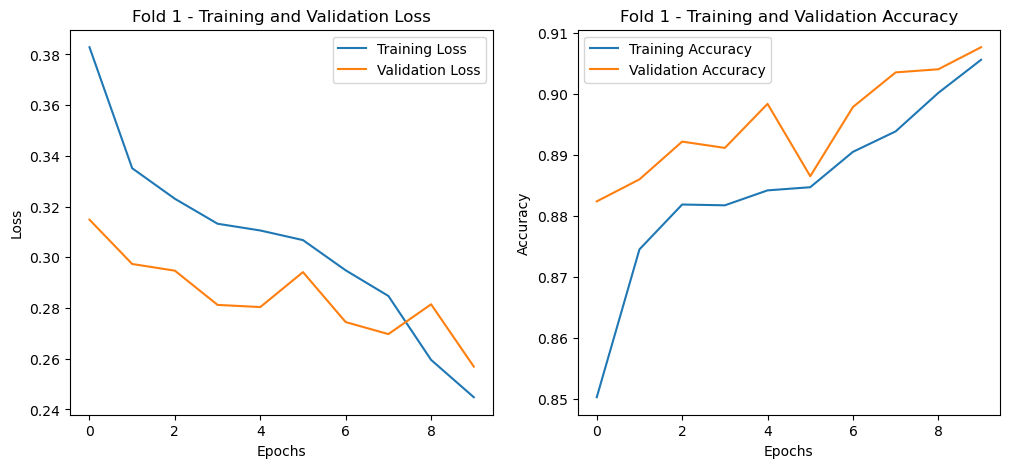

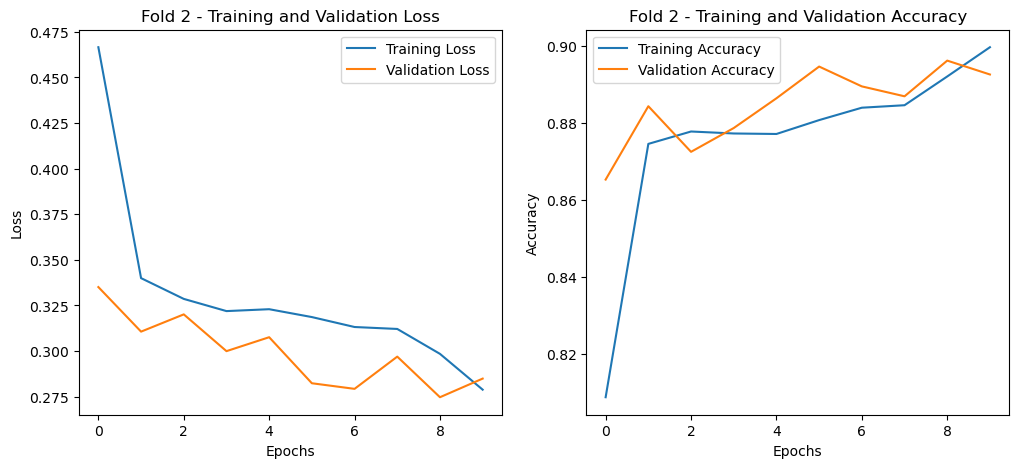

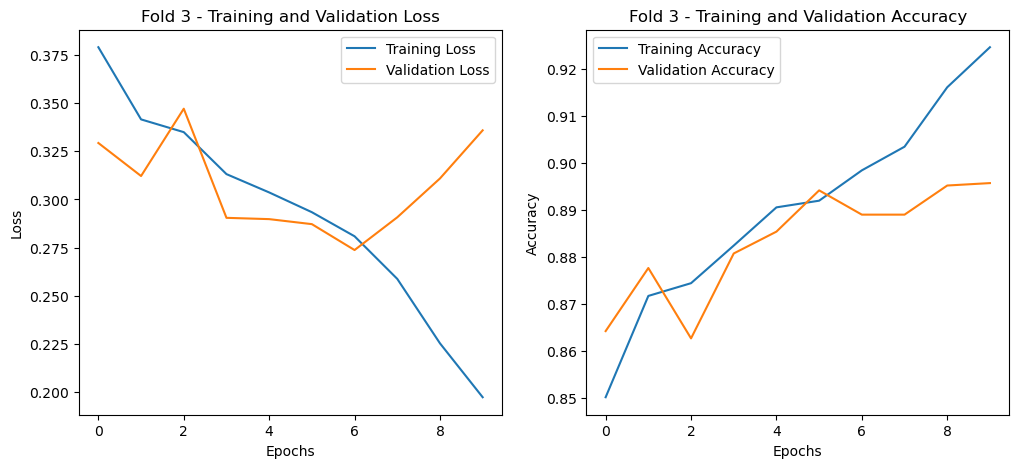

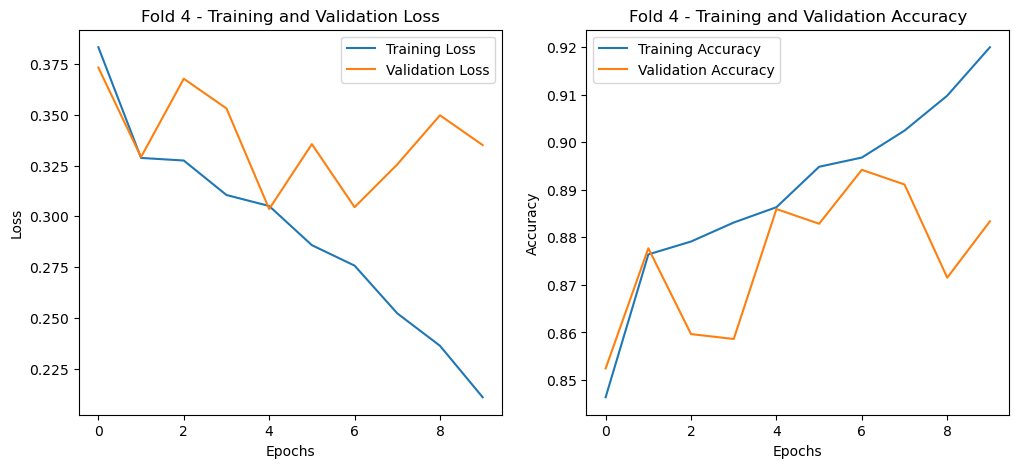

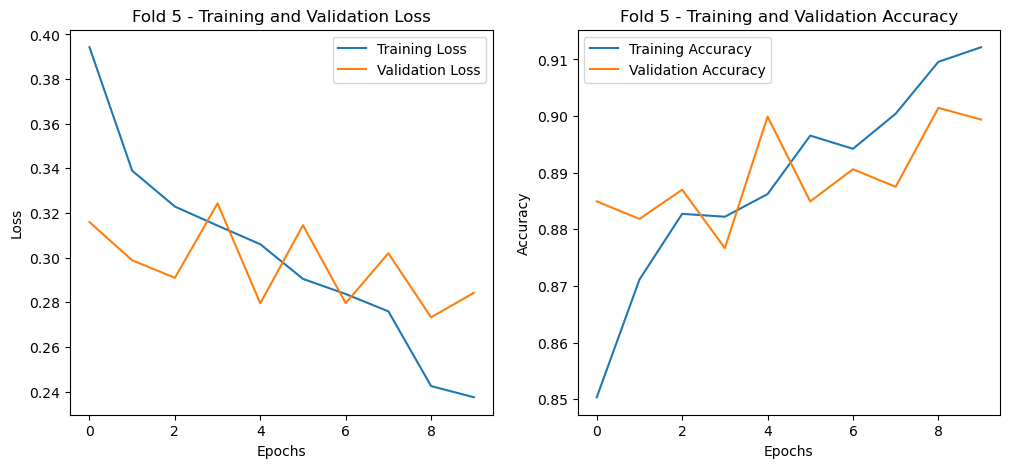

In [40]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Step 3: Classifying Unlabelled Images
We'll use the already-trained CNN to predict whether the test images are benign or malignant.

### Loading the Test Images

In [42]:
def load_test_images(folder):
    images = []
    image_names = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(128, 128))
        img_array = img_to_array(img)
        images.append(img_array)
        image_names.append(filename)
    return np.array(images), image_names

test_folder = 'Dataset2/test'
X_test, test_image_names = load_test_images(test_folder)
X_test = X_test / 255.0

### Using the Already-Trained Model for Predictions

In [47]:
predictions = last_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # converting one-hot to class labels

# mapping predictions to labels
predicted_labels = ['Benign' if label == 0 else 'Malignant' for label in predicted_classes]

for image_name, label in zip(test_image_names, predicted_labels):
    print(f'Image: {image_name}, Prediction: {label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Image: eight.png, Prediction: Malignant
Image: eleven.png, Prediction: Malignant
Image: five.png, Prediction: Malignant
Image: four.png, Prediction: Malignant
Image: fourteen.png, Prediction: Malignant
Image: nine.png, Prediction: Malignant
Image: one.png, Prediction: Benign
Image: seven.png, Prediction: Malignant
Image: six.png, Prediction: Benign
Image: ten.png, Prediction: Malignant
Image: thirteen.png, Prediction: Malignant
Image: three.png, Prediction: Malignant
Image: twelve.png, Prediction: Benign
Image: two.png, Prediction: Benign


Given the fact that the true labels of the test images was not given, there's no way to know which of these predictions are incorrect. However, going by degree of pink color/ white color for malignant and benign respectively, it is safe to assume the CNN model classified the test images correctly.